In [961]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [962]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [1089]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load the data
dataset = torch.load(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\dataset.pkl', map_location=device)

cpu


In [1091]:
# Get the first graph in the dataset
data = dataset[450].clone()

In [1028]:
data = dataset[10].clone()

In [1092]:
data.behaviour_names

Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object')

In [1093]:
data.frame_mask

tensor([450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455,
        456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458,
        459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450,
        451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453,
        454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451,
        452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454,
        455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457,
        458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 4

In [1094]:
node_features = data.x
edge_index = data.edge_index.numpy()
frame_mask = data.frame_mask

In [1095]:
# Eliminate repeated edges 
edge_index = np.unique(edge_index, axis=1)

In [1096]:
# Plot the graph
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G1 = nx.Graph()
G.add_nodes_from(range(node_features.shape[0]))
G1.add_nodes_from(range(node_features.shape[0]))
edge_color = []
edge1_color = []
edges = []
for edge in edge_index.T:
    if (edge[0], edge[1]) in edges or (edge[1], edge[0]) in edges:
            print('Already in')
            print(edge)
    #if node_features[edge[0], 4] != node_features[edge[1], 4]:
    if frame_mask[edge[0]] != frame_mask[edge[1]]:
        G1.add_edge(edge[0], edge[1], color='r')
        edges.append((edge[0], edge[1]))
        edge1_color.append('g')
        print('r')
    else:
        edges.append((edge[0], edge[1]))
        G.add_edge(edge[0], edge[1], color='k')
        edge_color.append('k')

#G.add_edges_from(edge_index.T.tolist())

r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
Already in
[198   0]
Already in
[198 176]
r
Already in
[199   1]
Already in
[199 177]
r
Already in
[200   2]
Already in
[200 178]
r
Already in
[201   3]
Already in
[201 179]
r
Already in
[202   4]
Already in
[202 180]
r
Already in
[203   5]
Already in
[203 181]
r
Already in
[204   6]
Already in
[204 182]
r
Already in
[205   7]
Already in
[205 183]
r
Already in
[206   8]
Already in
[206 184]
r
Already in
[207   9]
Already in
[207 185]
r
Already in
[208  10]
Already in
[208 186]
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r
r


In [1097]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [1098]:
node_features[:,4]

IndexError: index 4 is out of bounds for dimension 1 with size 4

In [1099]:
data.frame_mask

tensor([450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455,
        456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458,
        459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450,
        451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453,
        454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459,
        460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451,
        452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454,
        455, 456, 457, 458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457,
        458, 459, 460, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452,
        453, 454, 455, 456, 457, 458, 459, 460, 450, 451, 452, 4

In [1100]:
# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
# Put different colors to the nodes depending on the node features
colors = node_features[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'y' for c in colors]

# Node sizes
size = 100
# alpha of the edges
alpha = 0.3
# Position of the nodes
pos = node_features[:, :2].numpy()
# Add data.frame_mask to the x coordinate
# Frame difference
frame_x_diff = data.frame_mask.numpy().copy()
# Normalize the frame difference
frame_x_diff = ((frame_x_diff - frame_x_diff.min())*2) / (frame_x_diff.max() - frame_x_diff.min())
pos[:, 0] += frame_x_diff


In [1101]:
frame_x_diff

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2,
       0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6,
       0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. ,
       1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4,
       1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8,
       2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. ,
       0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4,
       0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8,
       1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2,
       1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6,
       1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ,
       0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2,
       0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6,
       0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 0. , 0.2, 0.4, 0.6, 0.

In [1102]:
pos

array([[0.40483594, 0.55224794],
       [0.6048359 , 0.55224794],
       [0.76564217, 0.5343625 ],
       [0.9359281 , 0.4578625 ],
       [1.1286187 , 0.43245625],
       [1.3250188 , 0.42551666],
       [1.520089  , 0.42145416],
       [1.6998093 , 0.39549583],
       [1.8972219 , 0.34733334],
       [2.0841985 , 0.30901876],
       [2.2841985 , 0.30195   ],
       [0.35362655, 0.56319165],
       [0.55362654, 0.56319165],
       [0.72796404, 0.56319165],
       [0.90851873, 0.5167937 ],
       [1.1051563 , 0.4927104 ],
       [1.3025906 , 0.48804793],
       [1.49775   , 0.48693332],
       [1.6869812 , 0.46066043],
       [1.8687704 , 0.42249584],
       [2.0687704 , 0.39053124],
       [2.2687702 , 0.36136043],
       [0.38550937, 0.62925416],
       [0.58550936, 0.62925416],
       [0.7716078 , 0.6174146 ],
       [0.9659141 , 0.54830414],
       [1.1648313 , 0.5128521 ],
       [1.3641125 , 0.50805414],
       [1.5641125 , 0.50621665],
       [1.7473891 , 0.4590625 ],
       [1.

In [1103]:
# count values of data.frame_mask.numpy()
unique, counts = np.unique(data.frame_mask.numpy(), return_counts=True)
dict(zip(unique, counts))


{450: 36,
 451: 36,
 452: 36,
 453: 36,
 454: 36,
 455: 36,
 456: 36,
 457: 36,
 458: 36,
 459: 36,
 460: 36}

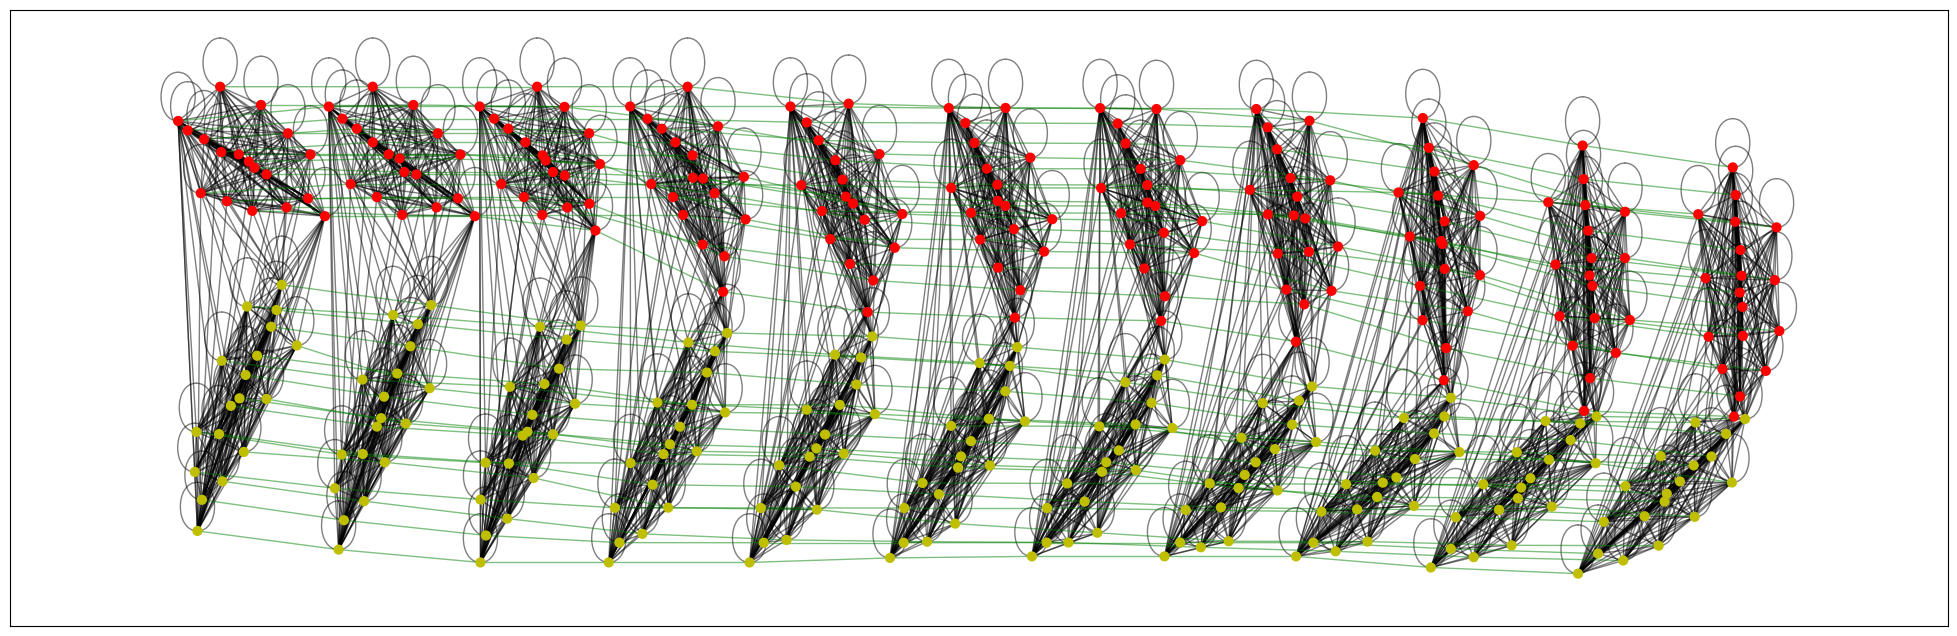

In [1104]:
# Plot the graph
plt.figure(figsize=(25, 8))
#pos = nx.spring_layout(G)
#nx.draw(G, pos, node_size=50, node_color=colors, alpha = 0.3)

nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=edge_color)
nx.draw_networkx_edges(G1, pos, alpha=0.5, edge_color=edge1_color)
#nx.draw(G, pos, node_size=50, node_color=colors)
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
plt.show()

In [1076]:
# Lets only plot the nodes that are in a same frame
nodes_features_to_keep = node_features[node_features[:,4]==0]

IndexError: index 4 is out of bounds for dimension 1 with size 4

In [819]:
nodes_features_to_keep.shape

torch.Size([36, 5])

In [820]:
# edge_index of the nodes that are in the same frame
G = nx.Graph()

# Get the indices of the nodes that are in the same frame
nodes_in_frame = np.where(node_features[:,4]==0)[0]
nodes_features_to_keep = node_features[node_features[:,4]==0]

G.add_nodes_from(nodes_in_frame)

edge_index = edge_index.numpy()

# Keep only the edges that are between nodes in the same frame
for i in range(edge_index.shape[1]):
    if edge_index[0, i] in nodes_in_frame and edge_index[1, i]in nodes_in_frame:
        G.add_edge(edge_index[0, i], edge_index[1, i])



In [836]:
G.number_of_nodes()

36

In [822]:
G.edges

EdgeView([(0, 0), (0, 90), (0, 95), (0, 100), (0, 110), (0, 115), (0, 135), (0, 140), (0, 145), (0, 150), (0, 170), (0, 5), (0, 10), (0, 15), (0, 20), (0, 25), (0, 30), (0, 35), (0, 40), (0, 45), (0, 50), (0, 55), (0, 60), (0, 65), (0, 70), (0, 75), (0, 80), (0, 85), (5, 5), (5, 10), (5, 15), (5, 20), (5, 25), (5, 30), (5, 35), (5, 40), (5, 45), (5, 50), (5, 55), (5, 60), (5, 65), (5, 70), (5, 75), (5, 80), (5, 85), (5, 90), (5, 170), (10, 10), (10, 15), (10, 20), (10, 25), (10, 30), (10, 35), (10, 40), (10, 45), (10, 50), (10, 55), (10, 60), (10, 65), (10, 70), (10, 75), (10, 80), (10, 85), (10, 90), (10, 170), (15, 15), (15, 20), (15, 25), (15, 30), (15, 35), (15, 40), (15, 45), (15, 50), (15, 55), (15, 60), (15, 65), (15, 70), (15, 75), (15, 80), (15, 85), (20, 20), (20, 25), (20, 30), (20, 35), (20, 40), (20, 45), (20, 50), (20, 55), (20, 60), (20, 65), (20, 70), (20, 75), (20, 80), (20, 85), (20, 90), (20, 170), (25, 25), (25, 30), (25, 35), (25, 40), (25, 45), (25, 50), (25, 55),

In [823]:
nodes_in_frame

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175], dtype=int64)

In [824]:
edge_index

array([[  0,   0,   0, ..., 179, 179, 179],
       [  0,   1,  90, ..., 164, 169, 174]], dtype=int64)

In [825]:
G.nodes

NodeView((0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175))

In [826]:
edge_index[0, 0]
edge_index[1, 0]

0

In [827]:
nodes_features_to_keep[:,:2].numpy()

array([[0.7794078 , 0.52608544],
       [0.73542655, 0.4834146 ],
       [0.74851876, 0.5344833 ],
       [0.75856876, 0.51437914],
       [0.6923453 , 0.51797706],
       [0.7453188 , 0.63843334],
       [0.71095   , 0.5550875 ],
       [0.6877359 , 0.5883375 ],
       [0.6673172 , 0.612525  ],
       [0.64659846, 0.5829333 ],
       [0.70296717, 0.6468083 ],
       [0.5968125 , 0.6252    ],
       [0.6672016 , 0.714875  ],
       [0.64785624, 0.6494188 ],
       [0.623075  , 0.6792458 ],
       [0.60155624, 0.69859165],
       [0.58605313, 0.718075  ],
       [0.6822182 , 0.6050512 ],
       [0.6908609 , 0.7264729 ],
       [0.7750406 , 0.74471456],
       [0.7514469 , 0.6756458 ],
       [0.7352312 , 0.7183375 ],
       [0.8009078 , 0.72377086],
       [0.74939376, 0.59491456],
       [0.7881687 , 0.67997915],
       [0.80253905, 0.65124583],
       [0.8173406 , 0.62525   ],
       [0.8577422 , 0.6526875 ],
       [0.7727672 , 0.6082917 ],
       [0.88262653, 0.58115417],
       [0.

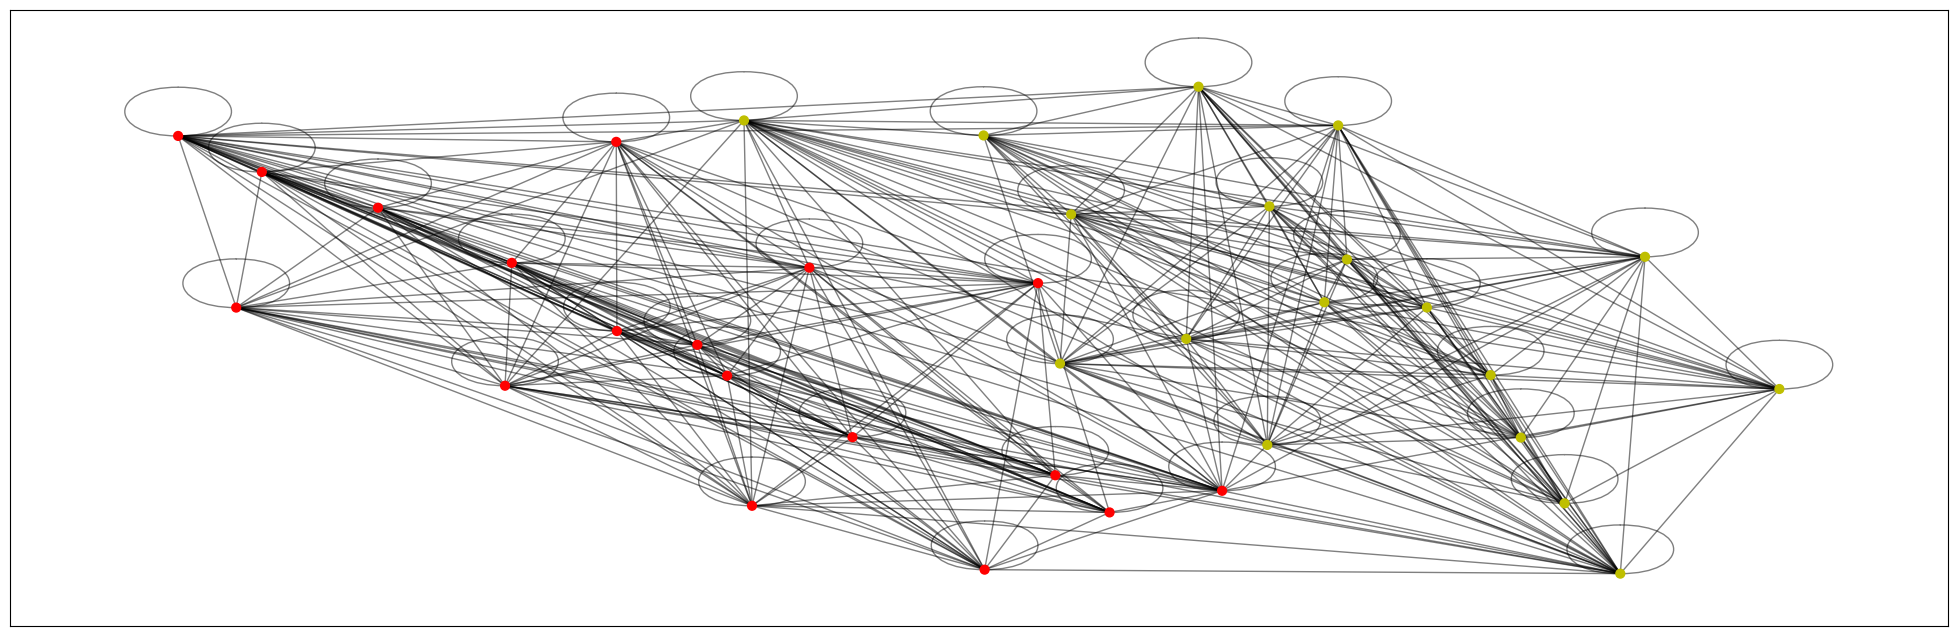

In [833]:


# The position of the nodes is the node features (first two dimensions), add +1 in x coord for different frames
pos = node_features[:, :2].numpy()
# mappi
colors = nodes_features_to_keep[:, 3].numpy()
# if colors is 0 -> red, if 1 -> yellow
colors = ['r' if c == 0 else 'y' for c in colors]

# Plot
plt.figure(figsize=(25, 8))
nx.draw_networkx_nodes(G, pos, node_size=40, node_color=colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

